In [1]:
import os
import sys
sys.path.append("../planning_centerline_calc")
from src.full_pipeline.full_pipeline import PathPlanner
from src.utils.cone_types import ConeTypes
# from planning_centerline_calc.planning_centerline_calc.utils.math_utils import unit2dVectorFromAngle
import json
import matplotlib.pyplot as plt
from scipy.spatial import distance
import numpy as np
import random
import math

In [2]:
train_dir ="./inputs/JSON/train"

In [3]:
def plotSamples(x_blue, y_blue, x_yellow, y_yellow, x_path, y_path):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_blue, y_blue, marker='o', linestyle='-', color='blue', label='Blue Cones', markersize=4)
    plt.plot(x_yellow, y_yellow, marker='o', linestyle='-', color='yellow', label='Yellow Cones', markersize=4)
    plt.plot(x_path, y_path, marker='', linestyle='-', color='black', label='Path')
   
    # Customize plot if needed
    # plt.title('Midpoints between Blue and Yellow Cones')
    # plt.xlabel('X Coordinate')
    # plt.ylabel('Y Coordinate')
    # plt.legend()
    # plt.grid(True)

    # Show the plot
    # plt.show()

In [4]:

def readJsonFile(tracks):
        with open(tracks, 'r') as file:
                json_data = json.load(file)
        json_data["color"][0] = "blue"
        x_blue = [json_data["x"][i] for i in range(len(json_data["color"])) if json_data["color"][i] == "blue" ]
        y_blue = [json_data["y"][i] for i in range(len(json_data["color"])) if json_data["color"][i] == "blue" ]
        x_yellow = [json_data["x"][i] for i in range(len(json_data["color"])) if json_data["color"][i] == "yellow"]
        y_yellow = [json_data["y"][i] for i in range(len(json_data["color"])) if json_data["color"][i] == "yellow"]
        x_yellow.append(x_yellow[0])
        y_yellow.append(y_yellow[0])
        return x_blue, y_blue, x_yellow, y_yellow

In [5]:

def findClosestBlue(yellow_x, yellow_y, x_blue, y_blue):
    distances = [distance.euclidean((yellow_x, yellow_y), (blue_x, blue_y)) for blue_x, blue_y in zip(x_blue, y_blue)]
    closest_blue_index = distances.index(min(distances))
    return x_blue[closest_blue_index], y_blue[closest_blue_index]
def calculateMidpoints(yellow_x, yellow_y, x_blue, y_blue):
    division_factors = [1, 2, 3]  # You can add more values if needed
    midpoints = []

    for factor in division_factors:
        closest_blue_x, closest_blue_y = findClosestBlue(yellow_x, yellow_y,x_blue, y_blue)
        midpoint_x = (yellow_x + closest_blue_x) / factor
        midpoint_y = (yellow_y + closest_blue_y) / factor
        midpoints.append((midpoint_x, midpoint_y))

    # Choose the midpoint that is most in the middle
    middle_index = len(midpoints) // 2  # Index of the middle value
    return midpoints[middle_index]
def generateMidpoints(x_blue, y_blue, x_yellow, y_yellow):
    x_path, y_path = zip(*[calculateMidpoints(yellow_x, yellow_y,x_blue,y_blue) for yellow_x, yellow_y in zip(x_yellow, y_yellow)])
    x_path = list(x_path)
    y_path = list(y_path)
    for i in range(1, len(x_path), 2):
        if len(x_path) < len(x_blue):
            x_midpoint = (x_path[i - 1] + x_path[i]) / 2
            y_midpoint = (y_path[i - 1] + y_path[i]) / 2
            x_path.insert(i, x_midpoint)
            y_path.insert(i, y_midpoint)
        else:
            break
    return x_path, y_path
    

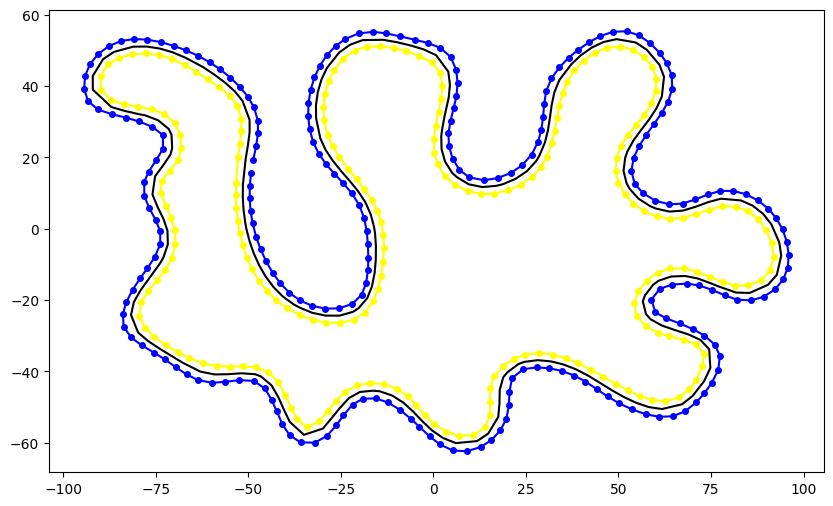

In [6]:
track = os.path.join(train_dir, "track (10).json")
x_blue, y_blue, x_yellow, y_yellow = readJsonFile(track)
x_path, y_path = generateMidpoints(x_blue, y_blue, x_yellow, y_yellow)
plotSamples(x_blue, y_blue, x_yellow, y_yellow, x_path, y_path)

In [7]:
def create_semicircle(center, direction, radius):

    # Calculate the starting and ending angles of the semicircle
    start_angle = direction - np.pi/2  # 90 degrees counter-clockwise from the direction
    end_angle = direction + np.pi/2    # 90 degrees clockwise from the direction

    # Generate angles from start_angle to end_angle
    angles = np.linspace(start_angle, end_angle, 100)

    # Calculate x and y coordinates of the semicircle points
    x = center[0] + radius * np.cos(angles)
    y = center[1] + radius * np.sin(angles)
    return x, y



-19.889271427041592 -45.81771799951655


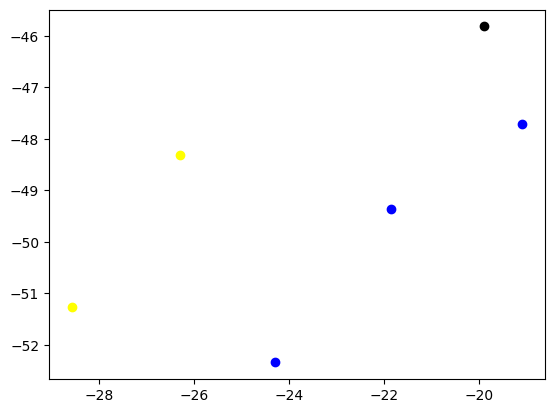

In [37]:
# get a random starting position
randIdx = random.randint(0, len(x_path)-1)
startX = x_path[randIdx]
startY = y_path[randIdx]
# startX = -39
# startY= 10
print(startX, startY)

radius = 11
startDir = math.atan2(y_path[randIdx+1] - startY, x_path[randIdx+1] - startX)
# startDir = -0.47
Maskx, Masky = create_semicircle([startX, startY], startDir, radius)


cones_blue = np.array(list(zip(x_blue, y_blue)))
cones_yellow = np.array(list(zip(x_yellow, y_yellow)))

def is_inside_semicircle(center, direction, radius, cones):
    # Calculate the starting and ending angles of the semicircle
    start_angle = direction - np.pi/2   # 90 degrees counter-clockwise from the direction
    end_angle = direction + np.pi/2   # 90 degrees clockwise from the direction

    # Prepare arrays to store results
    angle_within_range = np.zeros(len(cones), dtype=bool)
    distance_within_radius = np.zeros(len(cones), dtype=bool)

    # Iterate over each cone and check conditions
    for i, cone in enumerate(cones):
        # Calculate the vector from the center to the cone
        vector_to_cone = cone - center

        # Calculate the angle between the vector and the x-axis
        angle_to_cone = np.arctan2(vector_to_cone[1], vector_to_cone[0])

        # Check if the angle to the cone is within the range of the semicircle
        angle_within_range[i] = start_angle <= angle_to_cone <= end_angle
        # Check if the distance from the center to the cone is within the radius
        distance_within_radius[i] = np.linalg.norm(vector_to_cone) <= radius
        # if distance_within_radius[i]:
        #     print(angle_to_cone)

    # Return True for cones that satisfy both conditions
    # print(cones[angle_within_range==True])

    # plt.scatter(cones[distance_within_radius==True][:,0], cones[distance_within_radius==True][:,1])
    return angle_within_range & distance_within_radius
cones_blue = np.array(cones_blue)
cones_yellow = np.array(cones_yellow)
startPos = np.array([startX, startY])
coneBlueINSemiCircle = cones_blue[is_inside_semicircle(startPos, startDir, radius, cones_blue)]
conesYellowInSemiCircle = cones_yellow[is_inside_semicircle(startPos, startDir, radius, cones_yellow)]
# print(startPos)
plt.scatter(coneBlueINSemiCircle[:,0], coneBlueINSemiCircle[:,1], marker='o', c='blue', label='Blue Cones')
plt.scatter(conesYellowInSemiCircle[:,0], conesYellowInSemiCircle[:,1], marker='o', c='yellow', label='Yellow Cones')
plt.scatter(startPos[0], startPos[1], marker='o', c='black')

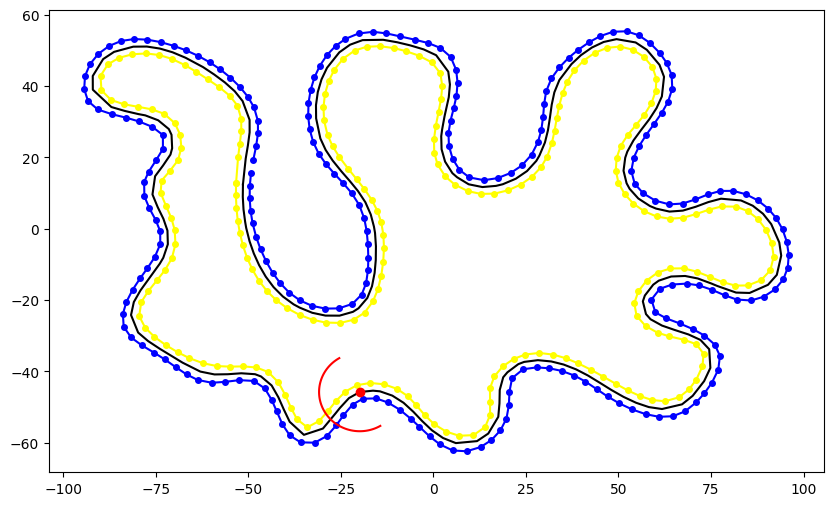

In [38]:
plotSamples(x_blue, y_blue, x_yellow, y_yellow, x_path, y_path)
plt.plot(startX, startY, marker = 'o', color = "red")
plt.plot(Maskx, Masky, color = "red")
plt.show()

In [39]:
conesInput = [np.zeros((0, 2)) for _ in ConeTypes]
conesInput[ConeTypes.BLUE] = np.vstack((conesInput[ConeTypes.BLUE], coneBlueINSemiCircle))
conesInput[ConeTypes.YELLOW] = np.vstack((conesInput[ConeTypes.YELLOW], conesYellowInSemiCircle))
pathplanner = PathPlanner()
path = pathplanner.calculatePathInGlobalFrame(vehiclePosition=startPos, vehicleDirection=startDir, cones=conesInput)
path


array([[-19.87682363, -46.01733025],
       [-19.85182759, -46.41816554],
       [-20.59909743, -46.87217279],
       [-21.34636728, -47.32618004],
       [-22.09363712, -47.78018729],
       [-22.84090697, -48.23419454],
       [-23.16723689, -48.62927555],
       [-23.49356681, -49.02435656],
       [-23.81989673, -49.41943757],
       [-24.14622665, -49.81451858],
       [-24.47255657, -50.20959959],
       [-24.79888649, -50.6046806 ],
       [-25.12521641, -50.99976161],
       [-25.45154633, -51.39484262],
       [-26.16906982, -52.50637764],
       [-26.81390279, -53.66160078],
       [-27.38339548, -54.85576499],
       [-27.87520772, -56.08396317],
       [-28.28731856, -57.34114841],
       [-28.61803453, -58.62215466],
       [-28.86599666, -59.921718  ],
       [-29.03018601, -61.23449822]])

(-29.527553955032992,
 -18.585459265511684,
 -62.00533723338185,
 -45.04687898838011)

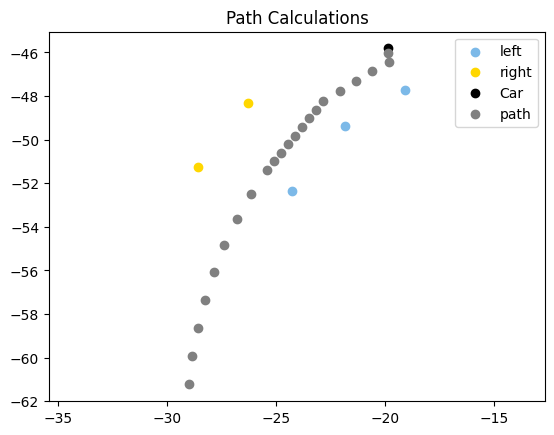

In [40]:
blue_color = "#7CB9E8"
yellow_color = "gold"

plt.scatter(coneBlueINSemiCircle[:, 0], coneBlueINSemiCircle[:, 1], c=blue_color, label="left")
plt.scatter(conesYellowInSemiCircle[:, 0], conesYellowInSemiCircle[:, 1], c=yellow_color, label="right")
# plt.scatter(cones_unknown[:, 0], cones_unknown[:, 1], c="k", label="unknown")
plt.scatter(startPos[0], startPos[1], c='black', label="Car")
plt.scatter(path[:,0], path[:,1], c='gray', label="path")
plt.legend()
plt.title("Path Calculations")
plt.axis("equal")

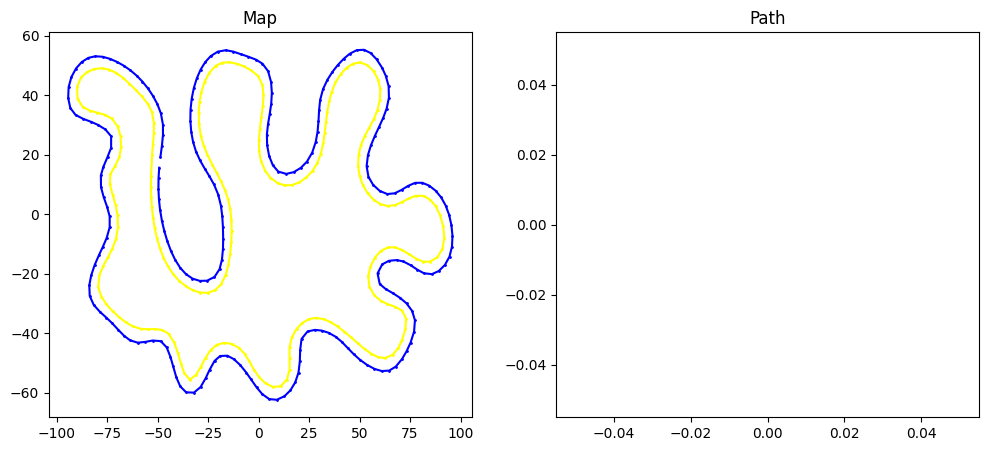

In [41]:
fig = plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

ax1.set_title("Map")
ax2.set_title("Path")

ax1.plot(x_blue, y_blue, marker='o', linestyle='-', color='blue', label='Blue Cones', markersize=1)
ax1.plot(x_yellow, y_yellow, marker='o', linestyle='-', color='yellow', label='Yellow Cones', markersize=1)

pos1, = ax1.plot([], [], marker = 'o', color = "red") # Position
SC, = ax1.plot([], [], color = "red") #SemiCircle
path1, = ax1.plot([], [], c='black', label="path") #Path

left2, = ax2.plot([], [], c=blue_color, label="left") #Left, Blue
right2, = ax2.plot([], [], c=yellow_color, label="right") #Right, Yellow
pos2, = ax2.plot([], [], marker = 'o', color = "red") # Position
path2, = ax2.plot([], [], c='black', label="path") #Path

In [42]:

def updatePaths(path, radius):
    paths = []
    Maskxs = []
    Maskys = []
    poss = []
    blues = []
    yellows = []
    
    for n in range (500):
        pos = path[int(len(path)/4)]
        dir = math.atan2(path[int(len(path)/4) + 1][1] - pos[1], path[int(len(path)/4) + 1][0] - pos[0])
        coneBlueINSemiCircle = cones_blue[is_inside_semicircle(pos, dir, radius, cones_blue)]
        conesYellowInSemiCircle = cones_yellow[is_inside_semicircle(pos, dir, radius, cones_yellow)]
        conesInput = [np.zeros((0, 2)) for _ in ConeTypes]
        conesInput[ConeTypes.BLUE] = np.vstack((conesInput[ConeTypes.BLUE], coneBlueINSemiCircle))
        conesInput[ConeTypes.YELLOW] = np.vstack((conesInput[ConeTypes.YELLOW], conesYellowInSemiCircle))
        # if len(coneBlueINSemiCircle) < 3 and len(conesYellowInSemiCircle) < 3:
        #     path = path[:]
        # else:
        print(pos)
        path = pathplanner.calculatePathInGlobalFrame(vehiclePosition=pos, vehicleDirection=dir, cones=conesInput)
        Maskx, Masky = create_semicircle(pos, dir, radius)
        paths.append(path)
        Maskxs.append(Maskx)
        Maskys.append(Masky)
        poss.append(pos)
        blues.append(coneBlueINSemiCircle)
        yellows.append(conesYellowInSemiCircle)
    return paths, Maskxs, Maskys, poss, blues, yellows
       
paths, Maskxs, Maskys, poss, blues, yellows = updatePaths(path, radius)
path = paths[-1][:]
def drawframe(n):
    pos1.set_data(poss[n][0], poss[n][1])
    # ax2.pos2.set_data(poss[n][0], poss[n][1])
    ax2.clear()
    pos2 = ax2.scatter(poss[n][0], poss[n][1], c='red')
    path1.set_data(paths[n][:,0], paths[n][:,1])
    # path2.set_data(paths[n][:,0], paths[n][:,1])
    path2 = ax2.scatter(paths[n][:,0], paths[n][:,1], c='black',)
    SC.set_data(Maskxs[n], Maskys[n])
    # left2.set_data(blues[n][:,0], blues[n][:,1])
    left2 = ax2.scatter(blues[n][:,0], blues[n][:,1], c=blue_color)
    # right2.set_data(yellows[n][:,0], yellows[n][:,1])
    right2 = ax2.scatter(yellows[n][:,0], yellows[n][:,1], c=yellow_color)
    return pos1, pos2, path1, path2, SC, left2, right2

[-22.84090697 -48.23419454]
[-25.29386387 -50.32906988]
[-28.62964603 -54.6469727 ]
[-31.70046237 -58.14365577]
[-36.0853358  -58.05564721]
[-38.10746421 -56.29552194]
[-38.65910567 -53.21927518]
[-41.32578668 -49.7988887 ]
[-42.78900472 -45.64916828]
[-45.51092091 -43.03120782]
[-46.68799644 -41.21505634]
[-49.68644883 -40.28797999]
[-54.04561714 -40.18548987]
[-58.04186198 -41.60098363]
[-62.5008876  -41.14888173]
[-64.01660102 -38.76743945]
[-66.00842835 -37.91976667]
[-68.21873793 -36.81889994]
[-70.95068244 -35.42418466]
[-75.46909268 -32.63992898]
[-77.78026772 -30.01127602]
[-80.09650563 -26.59576741]
[-81.31807286 -22.41167516]
[-80.1021448  -18.88428756]
[-78.95641922 -16.30997063]
[-77.35881522 -14.61464045]
[-74.93249208 -11.29450437]
[-72.98009887  -8.17099255]
[-72.30733066  -3.38995184]
[-71.8562128   -0.55337568]
[-72.94860469   2.74869841]
[-75.55108531   8.69513684]
[-75.4956932   13.97467865]
[-73.04130246  17.6987876 ]
[-70.81251962  21.65507374]
[-71.1177028   27.10

/home/mohd_yasser1/rt-ws/src/fs-system/planning/planning_centerline_calculation/../planning_centerline_calc/src/cones_sorting/cost_function.py:106: RuntimeWarning: invalid value encountered in true_divide
  costs: FloatArray = anglesAsCostFiltered.sum(axis=-1) / isPartOfConfiguration.sum(axis=-1)


[-48.68797065  -6.45686674]
[-48.02717102  -8.91632595]
[-46.63681922 -11.07118445]
[-45.30966756 -13.45532868]
[-43.18426683 -16.40839808]
[-40.67169368 -19.03878316]
[-37.75118186 -21.24853321]
[-34.40869727 -22.89008527]
[-30.93348842 -23.9996582 ]
[-26.31008301 -24.40232777]
[-20.98432141 -22.83728063]
[-17.54111253 -18.63346552]
[-16.59211235 -16.16943124]
[-16.0116189  -13.35384555]
[-15.72738751 -10.62387692]
[-15.56071889  -7.85478747]
[-15.53408008  -5.62326954]
[-15.70857072  -2.15588625]
[-16.27575862   1.39608437]
[-16.92385212   3.955617  ]
[-18.3751266    7.38330785]
[-19.90561307   9.79192954]
[-22.55808517  13.30410139]
[-24.67797529  15.42685099]
[-26.66487823  17.67456465]
[-27.68528168  19.8189349 ]
[-29.46791268  22.86145203]
[-31.03717784  24.69826849]
[-31.92992695  27.98624223]
[-31.68756555  30.91252331]
[-31.72592386  34.61305312]
[-32.008015    35.79395925]
[-31.23607893  38.29565337]
[-30.98648075  40.13763719]
[-29.48733185  43.46535664]
[-26.57231237  48.16

In [43]:
from matplotlib import animation
anim = animation.FuncAnimation(fig, drawframe, frames=500, interval=100)

In [44]:
from IPython.display import HTML
HTML(anim.to_html5_video())

In [ ]:
anim.save("planning_3.mp4")